# Table of Contents
 <p>

In [1]:
# https://fairyonice.github.io/Understand-Keras's-RNN-behind-the-scenes-with-a-sin-wave-example.html
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# http://philipperemy.github.io/keras-stateful-lstm/
# https://qiita.com/yukiB/items/5d5b202af86e3c587843

# https://datascience.stackexchange.com/questions/31923/training-an-lstm-to-track-sine-waves
# https://www.youtube.com/watch?v=BSpXCRTOLJA

In [2]:
import sys
print(sys.version)
import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)

import pandas as pd
import numpy as np
import math

import random
import matplotlib.pyplot as plt
%matplotlib inline

2.7.14 (default, Mar 10 2018, 00:01:11) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]


/Users/sebastian/work/git/stk/ml/waveforms/venv-wf/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.6.0
2.1.5


Using TensorFlow backend.


create period-10 sin wave with 500 cycles
In total, the sin wave time series length is 5001


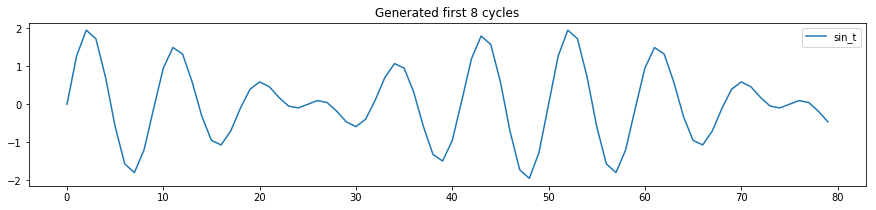

In [162]:
def noisy_sin(steps_per_cycle = 50,
              number_of_cycles = 500,
              random_factor = 0.4):
    '''
    random_factor    : amont of noise in sign wave. 0 = no noise
    number_of_cycles : The number of steps required for one cycle
    
    Return : 
    pd.DataFrame() with column sin_t containing the generated sin wave 
    '''
    random.seed(0)
    df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
    df["sin_t"] = df.t.apply(lambda x: math.sin(x * (1.2* 2 * math.pi / steps_per_cycle)) + math.sin(x * (2 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
    df["sin_t_clean"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)))
    print("create period-{} sin wave with {} cycles".format(steps_per_cycle,number_of_cycles))
    print("In total, the sin wave time series length is {}".format(steps_per_cycle*number_of_cycles+1))
    return(df)



steps_per_cycle = 10
df = noisy_sin(steps_per_cycle=steps_per_cycle,
              random_factor = 0)

n_plot = 8
df[["sin_t"]].head(steps_per_cycle * n_plot).plot(
      title="Generated first {} cycles".format(n_plot),
      figsize=(15,3))

In [163]:
# from pycbc import waveform

# hp, hc = waveform.get_td_waveform(approximant="SEOBNRv4_opt", mass1=30, mass2=30, f_lower=20, delta_t=1./1024 )

# plt.figure()
# plt.plot(hp.sample_times, hp)

# newt = range(len(hp.sample_times.numpy()))
# hp_df = pd.DataFrame(newt, columns=["t"])
# hp_df['hp'] = hp_df.t.apply(lambda x: hp.numpy()[x])

# hp_df['hp'].plot()

In [234]:
#create training and testing
def _load_data(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

length_of_sequences = 2
test_size = 0.25
ntr = int(len(df) * (1 - test_size))
df_train = df[["sin_t"]].iloc[:ntr]
df_test  = df[["sin_t"]].iloc[ntr:]
(X_train, y_train) = _load_data(df_train, n_prev = length_of_sequences)
(X_test, y_test)   = _load_data(df_test, n_prev = length_of_sequences)  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((3748, 2, 1), (3748, 1), (1249, 2, 1), (1249, 1))


In [235]:
y_train[0:3]

array([[1.94908324],
       [1.72156976],
       [0.71311849]])

In [236]:
ntr

3750

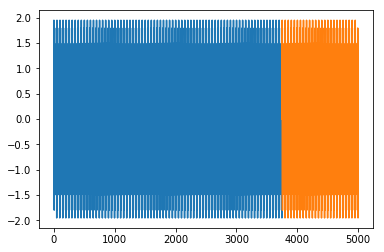

In [237]:
plt.figure()
plt.plot(df[['sin_t']][:ntr], label='train')
plt.plot(df[['sin_t']][ntr:], label='test')
# plt.xlim(0,100)

In [238]:
X_train[:,0].shape

(3748, 1)

(0, 100)

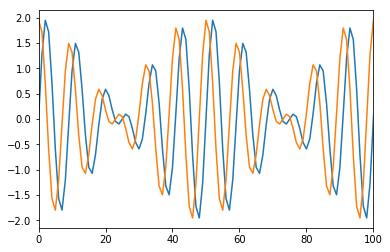

In [239]:
plt.figure()
plt.plot(X_train[:,0])
plt.plot(y_train)
plt.xlim(0,100)

In [55]:
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense, Activation 
from keras.layers.recurrent import SimpleRNN



def define_model(length_of_sequences, batch_size = None, stateful = False):
    in_out_neurons = 1
    hidden_neurons = 1
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  

    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN")(inp)

#     rnn = SimpleRNN(hidden_neurons, 
#                     return_sequences=True,
#                     stateful = stateful,
#                     name="RNN")(inp)
#     rnn2 = SimpleRNN(hidden_neurons, 
#                     return_sequences=False,
#                     stateful = stateful,
#                     name="RNN2")(rnn)
    
    dens = Dense(in_out_neurons,name="dense")(rnn)
#     dens = Dense(in_out_neurons,name="dense")(rnn2)
    model = Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error", optimizer="rmsprop")

    
    return(model,(inp,rnn,dens))
## use the default values for batch_size, stateful
model, (inp,rnn,dens) = define_model(length_of_sequences = X_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3, 1)              0         
_________________________________________________________________
RNN (SimpleRNN)              (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [56]:
hist = model.fit(X_train, y_train, batch_size=200, epochs=1000, 
                 verbose=False,validation_split=0.05)

In [57]:
hist.history.keys()

['loss', 'val_loss']

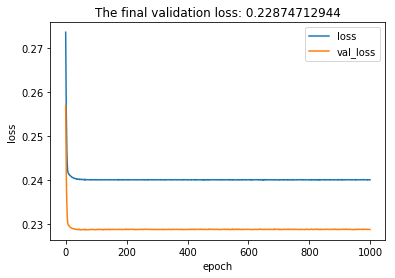

In [58]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

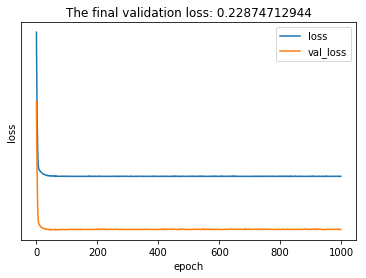

In [59]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.yscale('log')
plt.show()

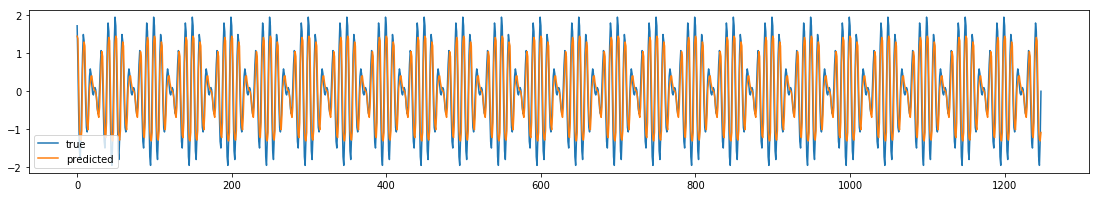

In [60]:
y_pred = model.predict(X_test)
plt.figure(figsize=(19,3))

plt.plot(y_test,label="true")
plt.plot(y_pred,label="predicted")
plt.legend()
# plt.xlim(0,100)
# plt.xlim(800,1000)
plt.show()

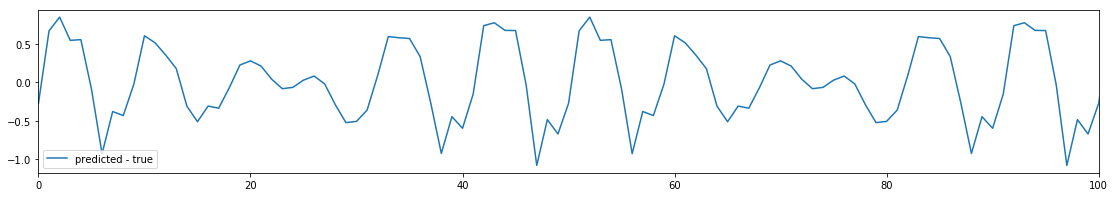

In [61]:
y_pred = model.predict(X_test)
plt.figure(figsize=(19,3))

plt.plot(y_pred - y_test,label="predicted - true")
plt.legend()
plt.xlim(0,100)
plt.show()

In [44]:
ws = {}
for layer in model.layers:
    ws[layer.name] = layer.get_weights()
ws

{'RNN': [array([[-0.29863513]], dtype=float32),
  array([[-1.]], dtype=float32),
  array([0.00043882], dtype=float32)],
 'dense': [array([[-2.7287405]], dtype=float32),
  array([-0.00407126], dtype=float32)],
 'input_2': []}